<a href="https://colab.research.google.com/github/nazihkhelifa/gokids/blob/main/Z_Image_Turbo_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/comfyanonymous/ComfyUI

%cd /content/ComfyUI
!pip install -r requirements.txt

!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/T5B/Z-Image-Turbo-FP8/resolve/main/z-image-turbo-fp8-e4m3fn.safetensors -d /content/ComfyUI/models/diffusion_models -o z-image-turbo-fp8-e4m3fn.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Comfy-Org/z_image_turbo/resolve/main/split_files/text_encoders/qwen_3_4b.safetensors -d /content/ComfyUI/models/clip -o qwen_3_4b.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Comfy-Org/z_image_turbo/resolve/main/split_files/vae/ae.safetensors -d /content/ComfyUI/models/vae -o ae.safetensors

fatal: destination path 'ComfyUI' already exists and is not an empty directory.
/content/ComfyUI
aria2 is already the newest version (1.36.0-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
68a8af|OK  |       0B/s|/content/ComfyUI/models/diffusion_models/z-image-turbo-fp8-e4m3fn.safetensors

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
ff0943|OK  |       0B/s|/content/ComfyUI/models/clip/qwen_3_4b.safetensors

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
dd7c15|OK  |       0B/s|/content/ComfyUI/models/vae/ae.safetensors

Status Legend:
(OK):download completed.


In [2]:
%cd /content/ComfyUI

import os, random, time

import torch
import numpy as np
from PIL import Image

from nodes import NODE_CLASS_MAPPINGS

UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
CLIPLoader = NODE_CLASS_MAPPINGS["CLIPLoader"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
CLIPTextEncode = NODE_CLASS_MAPPINGS["CLIPTextEncode"]()
KSampler = NODE_CLASS_MAPPINGS["KSampler"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    unet = UNETLoader.load_unet("z-image-turbo-fp8-e4m3fn.safetensors", "fp8_e4m3fn_fast")[0]
    clip = CLIPLoader.load_clip("qwen_3_4b.safetensors", type="lumina2")[0]
    vae = VAELoader.load_vae("ae.safetensors")[0]

@torch.inference_mode()
def generate(input):
    tmp_dir="/content/ComfyUI/output"
    os.makedirs(tmp_dir, exist_ok=True)

    values = input["input"]

    positive_prompt = values['positive_prompt']
    negative_prompt = values['negative_prompt']
    seed = values['seed'] # 0
    steps = values['steps'] # 9
    cfg = values['cfg'] # 1.0
    sampler_name = values['sampler_name'] # euler
    scheduler = values['scheduler'] # simple
    denoise = values['denoise'] # 1.0
    width = values['width'] # 1024
    height = values['height'] # 1024
    batch_size = values['batch_size'] # 1.0

    if seed == 0:
        random.seed(int(time.time()))
        seed = random.randint(0, 18446744073709551615)

    positive = CLIPTextEncode.encode(clip, positive_prompt)[0]
    negative = CLIPTextEncode.encode(clip, negative_prompt)[0]
    latent_image = EmptyLatentImage.generate(width, height, batch_size=batch_size)[0]
    samples = KSampler.sample(unet, seed, steps, cfg, sampler_name, scheduler, positive, negative, latent_image, denoise=denoise)[0]
    decoded = VAEDecode.decode(vae, samples)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save(f"{tmp_dir}/z_image_turbo.png")

    result = f"{tmp_dir}/z_image_turbo.png"

    return result

/content/ComfyUI


  0%|          | 0/9 [00:00<?, ?it/s]

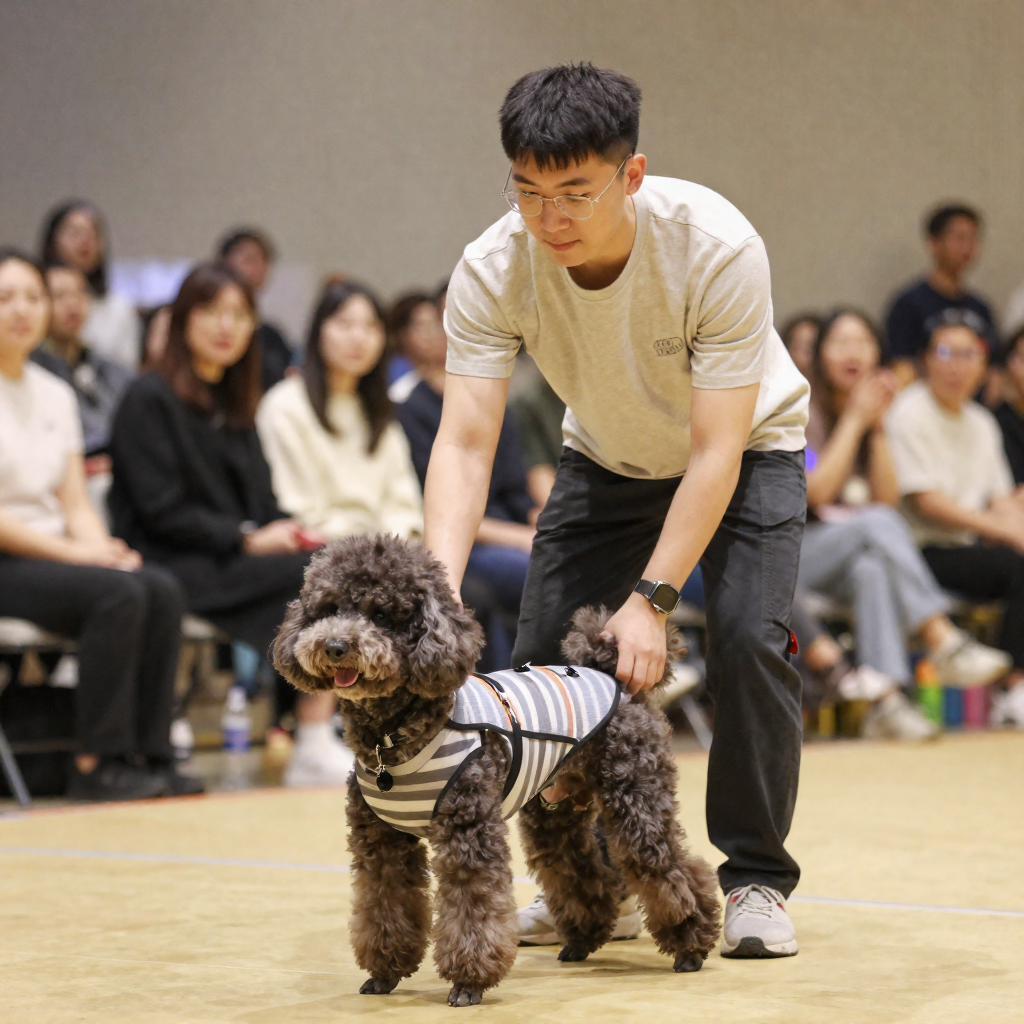

In [3]:
"""input = {
"input": {
"positive_prompt": "一位男士和他的贵宾犬穿着配套的服装参加狗狗秀，室内灯光，背景中有观众。",
"negative_prompt": "blurry ugly bad",
"width": 1024,
"height": 1024,
"batch_size": 1,
"seed": 0,
"steps": 9,
"cfg": 1,
"sampler_name": "euler",
"scheduler": "simple",
"denoise": 1.0,
}
}

output = generate(input)
Image.open(output)"""

In [3]:
import json

PROMPT_FILE = "/content/prompts.txt"

prompts = []

with open(PROMPT_FILE, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        obj = json.loads(line)
        prompt = obj.get("prompt", "").strip()

        if prompt:
            prompts.append(prompt)

print("Total prompts extracted:", len(prompts))
print("Sample prompt:\n")
print(prompts[0])


Total prompts extracted: 126
Sample prompt:

A photorealistic portrait photograph captures the gentle wisdom of an elderly Maori woman, her expressive dark eyes reflecting years of stories and traditions. Subtle tattoos known as moko adorn her face, telling tales of her lineage and personal journey. Soft, diffused natural light illuminates her deeply textured skin from the side, creating gentle shadows that enhance her distinguished features and the intricate patterns of her tattoos. The background is a softly blurred traditional meeting house, allowing her striking presence to take center stage.


In [4]:
def normalize_prompt(p):
    p = p.replace("\n", " ")
    p = " ".join(p.split())
    return p.strip()

prompts = [normalize_prompt(p) for p in prompts]


In [5]:
for i in range(3):
    print(f"\n--- PROMPT {i} ---")
    print(prompts[i])



--- PROMPT 0 ---
A photorealistic portrait photograph captures the gentle wisdom of an elderly Maori woman, her expressive dark eyes reflecting years of stories and traditions. Subtle tattoos known as moko adorn her face, telling tales of her lineage and personal journey. Soft, diffused natural light illuminates her deeply textured skin from the side, creating gentle shadows that enhance her distinguished features and the intricate patterns of her tattoos. The background is a softly blurred traditional meeting house, allowing her striking presence to take center stage.

--- PROMPT 1 ---
A middle-aged Caucasian male with deep-set blue eyes and a neatly trimmed salt-and-pepper beard, his weathered face adorned with fine laugh lines around the eyes. He gazes softly into the camera, a warm smile hinting at a lifetime of experiences, his gaze steady and reassuring. The photograph is taken from a slightly elevated angle, giving viewers a direct connection with his expressive eyes. The soft,

In [6]:
import inspect
import comfy
import comfy.model_management as mm

print(mm)


<module 'comfy.model_management' from '/content/ComfyUI/comfy/model_management.py'>


In [7]:
print(unet.model)
print(type(unet.model))


Lumina2(
  (diffusion_model): NextDiT(
    (x_embedder): Linear(in_features=64, out_features=3840, bias=True)
    (noise_refiner): ModuleList(
      (0-1): 2 x JointTransformerBlock(
        (attention): JointAttention(
          (qkv): Linear(in_features=3840, out_features=11520, bias=False)
          (out): Linear(in_features=3840, out_features=3840, bias=False)
          (q_norm): RMSNorm((128,), eps=None, elementwise_affine=True)
          (k_norm): RMSNorm((128,), eps=None, elementwise_affine=True)
        )
        (feed_forward): FeedForward(
          (w1): Linear(in_features=3840, out_features=10240, bias=False)
          (w2): Linear(in_features=10240, out_features=3840, bias=False)
          (w3): Linear(in_features=3840, out_features=10240, bias=False)
        )
        (attention_norm1): RMSNorm((3840,), eps=1e-05, elementwise_affine=True)
        (ffn_norm1): RMSNorm((3840,), eps=1e-05, elementwise_affine=True)
        (attention_norm2): RMSNorm((3840,), eps=1e-05, elemen

In [8]:
core = unet.model.diffusion_model

ffn_blocks = []

for name, module in core.named_modules():
    if module.__class__.__name__ == "FeedForward":
        ffn_blocks.append((name, module))

print("Total FeedForward blocks:", len(ffn_blocks))
print(ffn_blocks[0][0])


Total FeedForward blocks: 34
noise_refiner.0.feed_forward


In [9]:
from collections import defaultdict

activation_stats = defaultdict(list)

def make_gate_hook(name, gate):
    def hook(module, inp, out):
        # out shape: [B, T, 10240]
        activation_stats[f"{name}.{gate}"].append(
            out.detach().float().cpu()
        )
    return hook

hooks = []

for name, ff in ffn_blocks:
    h1 = ff.w1.register_forward_hook(make_gate_hook(name, "w1"))
    h3 = ff.w3.register_forward_hook(make_gate_hook(name, "w3"))
    hooks.extend([h1, h3])

print("Hooks registered:", len(hooks))


Hooks registered: 68


In [ ]:
_ = generate({
    "input": {
        "positive_prompt": prompts[0],
        "negative_prompt": "",
        "width": 256,
        "height": 256,
        "batch_size": 1,
        "seed": 42,
        "steps": 4,
        "cfg": 1,
        "sampler_name": "euler",
        "scheduler": "simple",
        "denoise": 1.0,
    }
})


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
print("Collected tensors:", len(activation_stats))
for k in list(activation_stats.keys())[:2]:
    print(k, activation_stats[k][0].shape)
